In [1]:
import glob
import pickle
import numpy as np
from einops import rearrange, repeat
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
model_name = 'vae'

In [3]:
class VRTaskTrial:
    def __init__(
        self,
        session: str,
        neural: np.ndarray,
        position: np.ndarray,
        view_angle: np.ndarray,
        velocity: np.ndarray,
        angular_velocity: np.ndarray,
        masked: bool, cues: np.ndarray
    ):
        self.session = session
        self.neural = MinMaxScaler().fit_transform(np.nan_to_num(neural))
        self.position = position
        self.view_angle = view_angle
        self.velocity = velocity
        self.angular_velocity = angular_velocity
        self.masked = masked
        self.cues = cues

    def num_neural_ts(self):
        return self.neural.shape[0]
    
    def num_neurons(self):
        return self.neural.shape[1]
    
    def num_behavioral_ts(self):
        return self.position.shape[0]

    def __len__(self):
        return self.neural.shape[0]

In [4]:
files = glob.glob('/home/hice1/smahato7/scratch/dop/data/' + '*.pkl')
data = []
for file in files:
    session_name = file.split('/')[-1].split('.')[0]
    session_obj = pickle.load(open(file, 'rb'))
    num_trials = session_obj['num_trials']
    for trial in range(num_trials):
        trial_obj = VRTaskTrial(
            session=session_name,
            neural=session_obj['df'][trial],
            position=session_obj['position'][trial],
            view_angle=session_obj['view_angle'][trial],
            velocity=session_obj['velocity'][trial],
            angular_velocity=session_obj['angular_velocity'][trial],
            masked=session_obj['trial_mask'][trial],
            cues=session_obj['cue_onsets'][trial]
        )
        data.append(trial_obj)

In [5]:
first_session_data = [d for d in data if d.session == data[0].session]

### VAE

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [26]:
BATCH_SIZE = 256
LATENT_DIM = 8
LEARNING_RATE = 1e-3
EPOCHS = 100
CHUNK_SIZE = 30 * 3

torch.cuda.set_device(0)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
def get_trial_split(session, train_prop=0.8):
    shuffled_trials = np.random.permutation(session)
    num_train = int(len(shuffled_trials) * train_prop)
    train_trials = shuffled_trials[:num_train]
    test_trials = shuffled_trials[num_train:]
    return train_trials, test_trials

In [28]:
def get_neural_split(session, train_prop=0.8):
    train_trials, test_trials = get_trial_split(session, train_prop)

    train_neural = np.concatenate([trial.neural for trial in train_trials], axis=0)
    T = train_neural.shape[0]
    train_chunks = [train_neural[i:i + CHUNK_SIZE] for i in range(0, T, CHUNK_SIZE) if i + CHUNK_SIZE < T]
    permuted_train_chunks = np.random.permutation(train_chunks)

    test_neural = [trial.neural for trial in test_trials]
    
    return permuted_train_chunks, test_neural

    # neural = np.concatenate([trial.neural for trial in session], axis=0)
    # T = neural.shape[0]
    # chunk_size = 30
    # chunks = [neural[i:i + chunk_size] for i in range(0, T, chunk_size) if i + chunk_size < T]
    # permuted_chunks = np.random.permutation(chunks)

    # num_train = int(len(permuted_chunks) * train_prop)
    # train_chunks = permuted_chunks[:num_train]
    # test_chunks = permuted_chunks[num_train:]
    # return train_chunks, test_chunks

In [29]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, latent_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim),
            torch.nn.ReLU()
        )

    def forward(self, x):
        latent_variables = self.encoder(x)
        reconstruction_data = self.decoder(latent_variables)
        return reconstruction_data

In [30]:
def vae_loss_function(recon_x, x, mu, logvar):
    """Combination of reconstruction loss and KL divergence."""
    recon_loss = nn.MSELoss()(recon_x, x)  # Reconstruction loss (MSE)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)  # KL divergence
    return recon_loss + kld_loss

In [31]:
# train is list of 1s chunks (30 x N), but test is list of trials (T x N)
train_data, test_data = get_trial_split(first_session_data, train_prop=0.8)
train_neural = np.concatenate([trial.neural for trial in train_data], axis=0)
train_data = torch.tensor(train_neural).to(DEVICE).type(torch.float32)
test_data = np.concatenate([trial.neural for trial in test_data], axis=0)
test_data = torch.tensor(test_data).to(DEVICE).type(torch.float32)

data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # collate_fn=lambda trial_objs: [torch.tensor(trial_obj) for trial_obj in trial_objs],
)



# Training Parameters
training_outputs = []
training_losses = []
validation_outputs = []
validation_losses = []

ae = Autoencoder(
    input_dim=train_data.shape[1],
    hidden_dim=(train_data.shape[1] + LATENT_DIM) // 2,
    latent_dim=LATENT_DIM,
).to(DEVICE)

# Step 1: using Mean-Squared-Error MSE Loss function
MSE_function = torch.nn.MSELoss().to(DEVICE)

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(ae.parameters(), lr=LEARNING_RATE)
# ----------------------------------------------

# for epoch in epoch_log:
#     total_loss = 0
#     for batch in data_loader:
#         optimizer.zero_grad()
#         batch_neural = torch.cat(batch, dim=0).to(DEVICE).type(torch.float32)
#         recon_batch, mu, logvar = vae(batch_neural)
#         loss = vae_loss_function(recon_batch, batch_neural, mu, logvar)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     epoch_log.set_description(f"VAE (epoch {epoch + 1}/{EPOCHS})")
#     epoch_log.set_postfix(loss=f"{total_loss / len(data_loader):.4f}")


t = tqdm(range(EPOCHS))
for epoch in t:
    ae.train()
    training_loss_this_epoch = 0.0
    for batch_idx, batch in enumerate(data_loader):
        reconstructed = ae(batch)
        loss = MSE_function(reconstructed, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss_this_epoch += float(loss.detach())

    training_loss_this_epoch /= len(data_loader)
    training_losses.append(training_loss_this_epoch)

    t.set_description("Training loss: "+str(training_loss_this_epoch), refresh=True)

    # # put model into evaluation mode
    # model.eval()
    # validation_loss_this_epoch = 0.0
    # # loop through your validation/validation data
    # for validation_batch_idx, validation_batch in enumerate(validation_loader):
    #     # STEP_5: pull out the data from your validation batch
    #     validation_batch_data = validation_batch['data']

    #     # STEP 6: get the reconstructed data from the Autoencoder Output
    #     reconstructed_validation = model(validation_batch_data)

    #     # STEP 7: calculate the loss function between the reconstrucion and original data
    #     validation_loss = MSE_function(reconstructed_validation, validation_batch_data)

    #     validation_loss_this_epoch += float(validation_loss.detach())

    # # STEP 8: append the averaged validation losses over batches to the validation loss list
    # validation_loss_this_epoch /= len(validation_loader)
    # validation_losses.append(validation_loss_this_epoch)

# return model, training_losses, validation_losses

Training loss: 0.03382101515643031: 100%|██████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


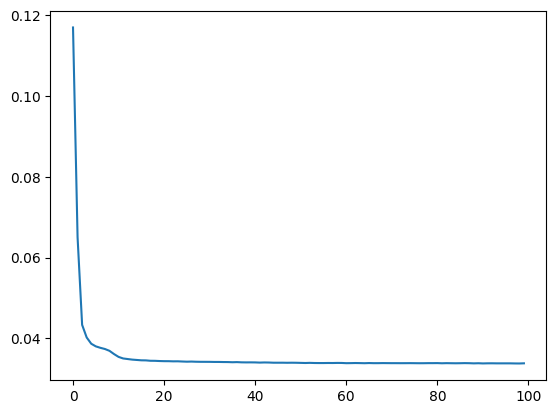

In [32]:
plt.plot(training_losses)

In [33]:
def evaluate_ae(ae, batch):
    # Testing with a single sample
    ae.eval()

    reconstructed = ae(batch)
    loss = MSE_function(reconstructed, batch)

    reconstructed = reconstructed.cpu().detach().numpy()
    batch = batch.cpu().detach().numpy()

    # Plot original and reconstructed samples
    # Plot them as heatmaps, with x axis the time and y axis the neuron index
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(batch.T, aspect='auto', cmap='viridis')
    plt.title('Original sample')
    plt.xlabel('Time')
    plt.ylabel('Neuron index')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.T, aspect='auto', cmap='viridis')
    plt.title('Reconstructed sample')
    plt.xlabel('Time')
    plt.ylabel('Neuron index')
    plt.tight_layout()
    plt.show()

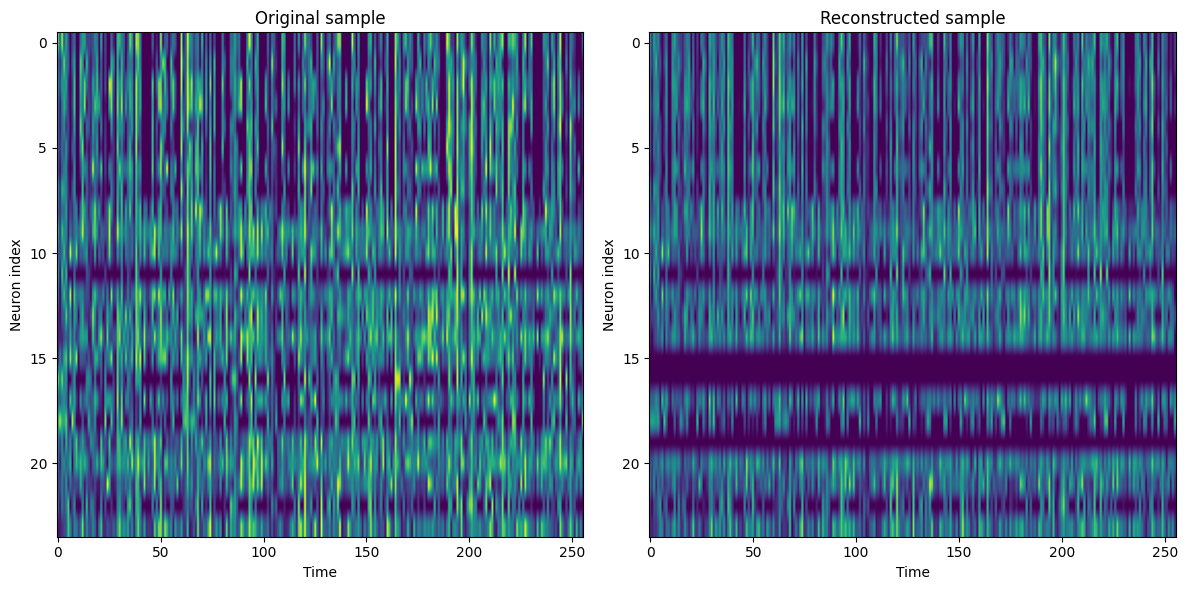

In [34]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=256,
    shuffle=True,
    # collate_fn=lambda trial_objs: [torch.tensor(trial_obj) for trial_obj in trial_objs],
)
batch = next(iter(test_loader))
evaluate_ae(ae, batch)

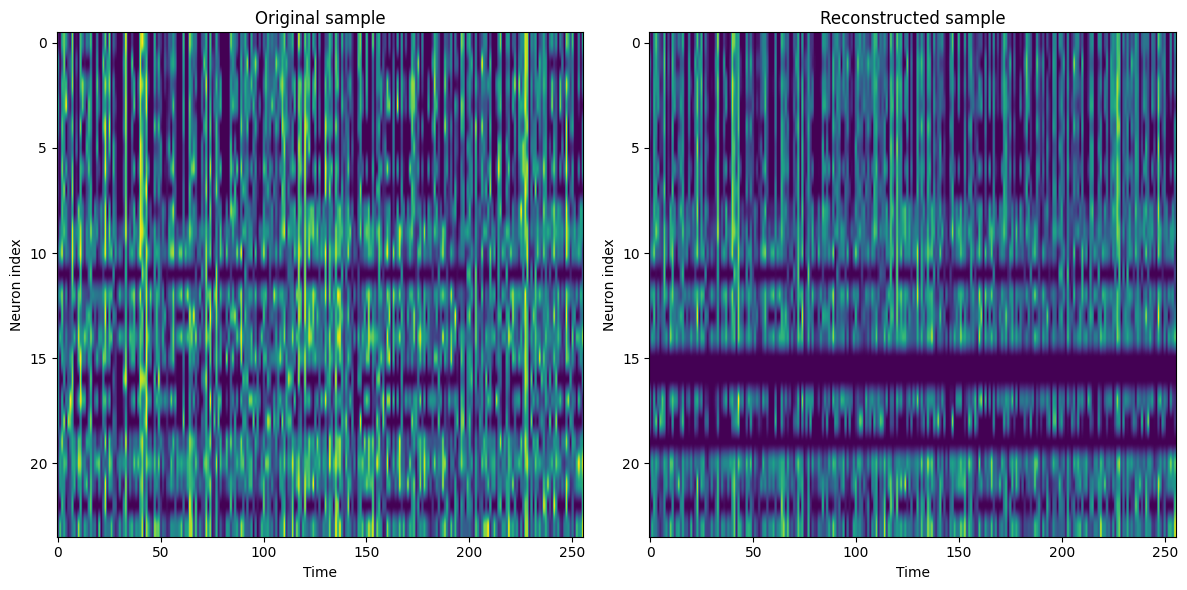

In [37]:
batch = next(iter(test_loader))
evaluate_ae(ae, batch)

In [ ]:
# train is list of 1s chunks (30 x N), but test is list of trials (T x N)
train_data, test_data = get_neural_split(first_session_data, train_prop=0.8)

data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda trial_objs: [torch.tensor(trial_obj) for trial_obj in trial_objs],
)

vae = VAE(input_dim=train_data[0].shape[1], latent_dim=LATENT_DIM)
vae.to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

vae.train()
epoch_log = tqdm(range(EPOCHS))
for epoch in epoch_log:
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        batch_neural = torch.cat(batch, dim=0).to(DEVICE).type(torch.float32)
        recon_batch, mu, logvar = vae(batch_neural)
        loss = vae_loss_function(recon_batch, batch_neural, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_log.set_description(f"VAE (epoch {epoch + 1}/{EPOCHS})")
    epoch_log.set_postfix(loss=f"{total_loss / len(data_loader):.4f}")

VAE (epoch 100/100): 100%|████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.62it/s, loss=0.0835]


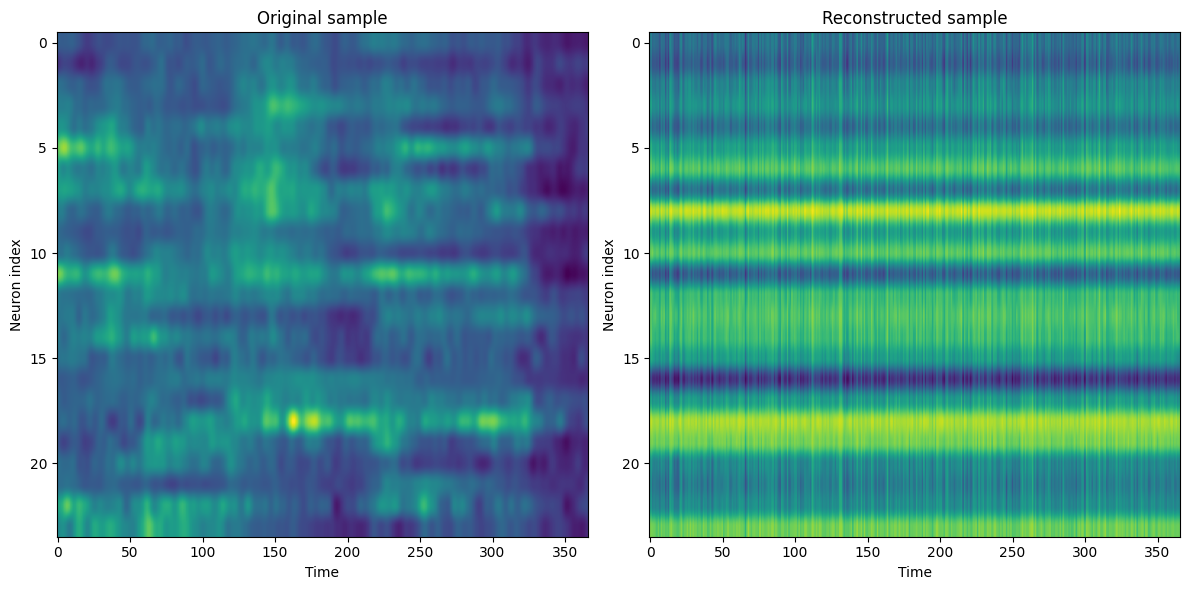

In [ ]:
# Testing with a single sample
vae.eval()
test_sample_trial = test_data[6]
test_sample_chunks = [test_sample_trial[i:i + 30] for i in range(0, test_sample_trial.shape[0], CHUNK_SIZE)]
test_sample_chunks = [torch.tensor(chunk).to(DEVICE).type(torch.float32) for chunk in test_sample_chunks]
reconstructed_chunks = []
for chunk in test_sample_chunks:
    reconstructed_chunk, _, _ = vae(chunk)
    reconstructed_chunk = reconstructed_chunk.cpu().detach().numpy()
    reconstructed_chunks.append(reconstructed_chunk)

total_reconstructed_sample = np.concatenate(reconstructed_chunks, axis=0)
test_sample = np.concatenate([chunk.cpu().detach().numpy() for chunk in test_sample_chunks], axis=0)

# Plot original and reconstructed samples
# Plot them as heatmaps, with x axis the time and y axis the neuron index
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_sample.T, aspect='auto', cmap='viridis')
plt.title('Original sample')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.subplot(1, 2, 2)
plt.imshow(total_reconstructed_sample.T, aspect='auto', cmap='viridis')
plt.title('Reconstructed sample')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

In [28]:
def linear_decode(pca, neural, covariate):
    best_r2 = -np.inf
    best_pred = None
    
    neural = np.nan_to_num(neural)
    centered_neural = neural - np.mean(neural, axis=0, keepdims=True)
    latent_vars = pca.transform(neural)

    X = latent_vars
    y = covariate
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_pred = y_pred
    
    return best_r2, best_pred

def decode_trials(trials, pca_model, covariate_name, progress=True):
    r2_vals = []
    pred_vals = []
    covariates = []
    it = tqdm(trials) if progress else trials
    for trial in it:
        r2, pred = linear_decode(pca_model, trial.neural[:-45,:], trial.__dict__[covariate_name])
        r2_vals.append(r2)
        pred_vals.append(pred)
        covariates.append(trial.__dict__[covariate_name])
    return r2_vals, pred_vals, covariates

In [ ]:
def vae_decode_multiple(session, covariate_name, times=10):
    all_train_r2s = []
    all_test_r2s = []
    all_n_components = []
    for _ in tqdm(range(times)):
        train_trials, test_trials = get_trial_splot(session)
        train_neural = np.concatenate([trial.neural[:-45,:] for trial in train_trials], axis=0)
        latent_vars_train, pca_model_train, n_components = perform_trial_pca(train_neural, variance_threshold=0.90)
        train_r2s, train_cov_preds, train_cov_gt = decode_trials(train_trials, pca_model_train, covariate_name, progress=False)
        test_r2s, test_cov_preds, test_cov_gt = decode_trials(test_trials, pca_model_train, covariate_name, progress=False)
        all_train_r2s.append(np.mean(train_r2s))
        all_test_r2s.append(np.mean(test_r2s))
        all_n_components.append(n_components)
    return np.mean(all_train_r2s), np.mean(all_test_r2s), np.mean(all_n_components), train_cov_preds, train_cov_gt, test_cov_preds, test_cov_gt

In [47]:
train_pos_r2, test_pos_r2, n_components_pos, train_pos_preds, train_pos_gt, test_pos_preds, test_pos_gt = pca_decode_multiple(first_session_data, 'position', times=30)
print(f"Position | Num Components: {n_components_pos} | Train R2: {train_pos_r2} | Test R2: {test_pos_r2}")

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]

Position | Num Components: 11.033333333333333 | Train R2: 0.7215838274379415 | Test R2: 0.7204045365065976


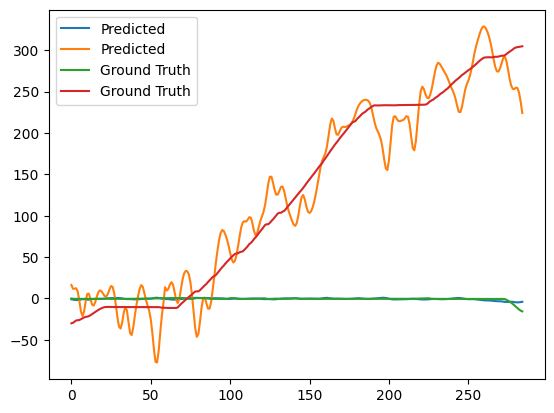

In [56]:
trial = 32
plt.plot(train_pos_preds[trial], label='Predicted')
plt.plot(train_pos_gt[trial], label='Ground Truth')
plt.legend()
plt.show()

In [45]:
train_va_r2, test_va_r2, n_components_va, train_va_preds, train_va_gt, test_va_preds, test_va_gt = pca_decode_multiple(first_session_data, 'view_angle', times=30)
print(f"View Angle | Num Components: {n_components_va} | Train R2: {train_va_r2} | Test R2: {test_va_r2}")

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

View Angle | Num Components: 11.2 | Train R2: 0.6930051330735642 | Test R2: 0.6925154901378953


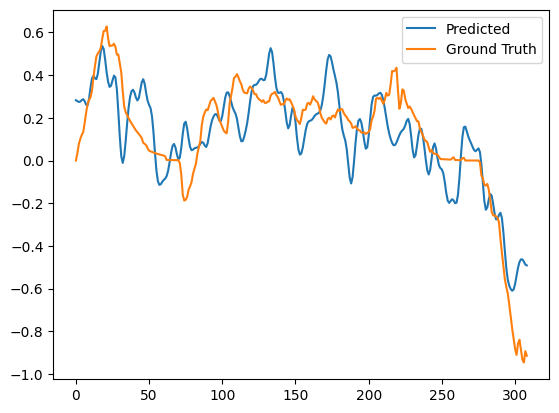

In [59]:
trial = 49
plt.plot(train_va_preds[trial], label='Predicted')
plt.plot(train_va_gt[trial], label='Ground Truth')
plt.legend()
plt.show()

In [60]:
# Velocity
train_vel_r2, test_vel_r2, n_components_vel, train_vel_preds, train_vel_gt, test_vel_preds, test_vel_gt = pca_decode_multiple(first_session_data, 'velocity', times=30)
print(f"Velocity | Num Components: {n_components_vel} | Train R2: {train_vel_r2} | Test R2: {test_vel_r2}")

100%|██████████| 30/30 [00:31<00:00,  1.07s/it]

Velocity | Num Components: 11.066666666666666 | Train R2: 0.586229991833489 | Test R2: 0.5863981683985711


### Across all sessions

In [73]:
def extract_results_across_sessions(covariate_names, session_results, times_each=10):
    session_names = set([d.session for d in data])
    for session_name in session_names:
        session_data = [d for d in data if d.session == session_name]
        if session_name not in session_results:
            session_results[session_name] = {}

        for covariate_name in covariate_names:
            print(f"Session: {session_name} | Covariate: {covariate_name}")
            if covariate_name in session_results[session_name]:
                print("Skipping...")
                continue
            train_r2, test_r2, n_components, train_preds, train_gt, test_preds, test_gt = pca_decode_multiple(session_data, covariate_name, times=times_each)
            session_results[session_name][covariate_name] = {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'n_components': n_components,
                'train_preds': train_preds,
                'train_gt': train_gt,
                'test_preds': test_preds,
                'test_gt': test_gt
            }
            print(f"Num Components: {n_components} | Train R2: {train_r2} | Test R2: {test_r2}")
            print()

In [87]:
session_results = {}
try:
    with open(f'output/{model_name}/session_results.pkl', 'rb') as f:
        session_results = pickle.load(f)
        print("Loaded previous results.")
        print(f"Saved covariates: {', '.join(session_results[list(session_results.keys())[0]].keys())}")
except FileNotFoundError:
    print("No previous results found, starting fresh.")

Loaded previous results.
Saved covariates: position, view_angle, velocity, angular_velocity


In [88]:
covariate_names = ['position', 'view_angle', 'velocity', 'angular_velocity']
extract_results_across_sessions(covariate_names, session_results, times_each=20)

Session: 151_1-17-18 | Covariate: position
Skipping...
Session: 151_1-17-18 | Covariate: view_angle
Skipping...
Session: 151_1-17-18 | Covariate: velocity
Skipping...
Session: 151_1-17-18 | Covariate: angular_velocity
Skipping...
Session: 14972_3-10-16 | Covariate: position
Skipping...
Session: 14972_3-10-16 | Covariate: view_angle
Skipping...
Session: 14972_3-10-16 | Covariate: velocity
Skipping...
Session: 14972_3-10-16 | Covariate: angular_velocity
Skipping...
Session: 14974_3-8-16 | Covariate: position
Skipping...
Session: 14974_3-8-16 | Covariate: view_angle
Skipping...
Session: 14974_3-8-16 | Covariate: velocity
Skipping...
Session: 14974_3-8-16 | Covariate: angular_velocity
Skipping...
Session: 803_2-22-17 | Covariate: position
Skipping...
Session: 803_2-22-17 | Covariate: view_angle
Skipping...
Session: 803_2-22-17 | Covariate: velocity
Skipping...
Session: 803_2-22-17 | Covariate: angular_velocity
Skipping...
Session: 697_12-7-16 | Covariate: position
Skipping...
Session: 697_

### Post-hoc analysis

In [70]:
for session_name, session_data in session_results.items():
    print(f"Session: {session_name}")
    has_negatives = False
    for covariate_name, covariate_data in session_data.items():
        if has_negatives or covariate_data['train_r2'] < 0 or covariate_data['test_r2'] < 0:
            has_negatives = True
            assert covariate_data['train_r2'] < 0 and covariate_data['test_r2'] < 0
    if not has_negatives:
        print(f"All good! {[d for d in data if d.session == session_name][0].neural.shape[1]}")
    else:
        print(f"Some negative R2s found! {[d for d in data if d.session == session_name][0].neural.shape[1]}")

Session: 151_1-17-18
All good! 15
Session: 14972_3-10-16
All good! 18
Session: 14974_3-8-16
All good! 23
Session: 803_2-22-17
All good! 17
Session: 697_12-7-16
All good! 19
Session: 145_1-23-18
Some negative R2s found! 12
Session: 147_1-19-18
Some negative R2s found! 4
Session: 927_8-2-17
Some negative R2s found! 13
Session: 14985_6-15-16
All good! 9
Session: 947_10-10-17_take_2_new_position
All good! 9
Session: 150_1-16-18
All good! 11
Session: 1003_1-7-18
All good! 7
Session: 556_8-9-16
All good! 20
Session: 5330_8-1-16_take_2
All good! 9
Session: 946_9-18-17
Some negative R2s found! 3
Session: 802_5-31-17
All good! 18
Session: 150_1-22-18
All good! 7
Session: 801_3-30-17
All good! 13
Session: 151_1-18-18
Some negative R2s found! 10
Session: 161_4-7-17
All good! 24
Session: 947_8-31-17
Some negative R2s found! 12
Session: 131_1-8-18
All good! 6
Session: 651_11-7-16
All good! 24


In [ ]:
pickle.dump(session_results, open(f'output/{model_name}/session_results.pkl', 'wb'))